In [1]:
using Pkg,Statistics,Random,Printf,GZip,Knet,Plots,LinearAlgebra,Distributions,StatsBase, Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3390053285884853572\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-637838902230365593\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/6cbf0fd219fa6416ec9b47399ab16ea685b891e3-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-3390053285884853572\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

## Generate training data

In [2]:
Random.seed!(4);
Range=3.0; # range of the x values for the target Gaussian function
Incr = 0.03; # Number of training examples = 3.0/0.03 = 100
Noise_std=0.1; # add noise on the Gaussian function

In [3]:
# generate the data from which we'll learn the Gaussian function
# obligatory arguments listed before ";" while optional arguments come after ";".
function gen_noisy_gaussian(;range=1.0,noise=0.1)
    x = collect(-Range:Incr:Range)
    y = exp.(-x.^2) + randn(length(x))*noise; # additive gaussian noise
    return (x,y)
end
# output is two vectors x,y

gen_noisy_gaussian (generic function with 1 method)

In [4]:
(x_train,y_train) = gen_noisy_gaussian(range=Range,noise=Noise_std);
pop!(x_train);pop!(y_train);

In [5]:
Ntrain =length(x_train) # number of training data points

200

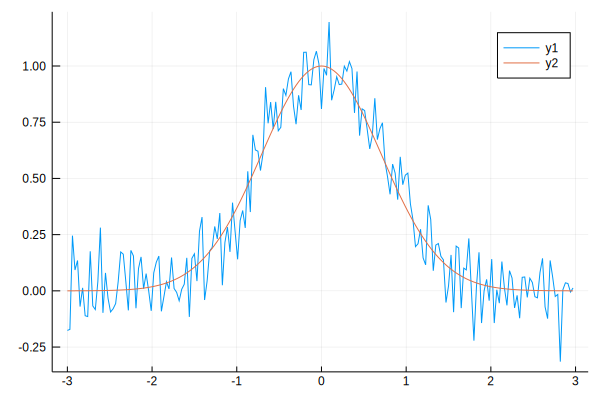

In [6]:
plot(x_train,[y_train,exp.(-x_train.^2)])

## Network + loss function

In [7]:
Batchsize = 10; # determines the degree of batch noise (smaller batchsize => larger noise)
RegWeight=0.001; # lambda for L2 regularization - sets the minimum of the Hessian eigenvalues
InitNorm = 0.5; # initial weight norm - not critical

In [8]:
Nweights = 7

7

In [9]:
function predict(w,x) # returns a row of predicted values for each sample in x
    return w[5:6]'*tanh.(w[1:2]*x' .+ w[3:4]) .+ w[7]
end

predict (generic function with 1 method)

In [10]:
# both x and y are ordered in columns per training data point
function sqloss(w,x,y)
    return mean(abs2,y'-predict(w,x))
end

function reg(w)
    return RegWeight*norm(w)^2
end

function loss(w,x,y)
    return sqloss(w,x,y) + reg(w)
end

loss (generic function with 1 method)

## Gradient

In [11]:
# grad() is a "functional" whose input and output is a function (loss). 
# The output function takes the same arguments as the input function.
# Requires input to be a scalar function and evaluates the gradient wrt elements of the first argument.
# Let ∇f = grad(f). f = f(x,y,z) => ∇f(x,y,z) = ∇ₓf with identical structure as x
lossgradient = grad(loss)
sqlossgradient = grad(sqloss)
reggradient = grad(reg)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(reg),Int64,Bool}}) (generic function with 1 method)

In [12]:
# calculate gradient at the initial w
# dw has dimensions of w: each weight wᵢ is replaced with the ∂/∂wᵢ
Random.seed!(2);
@show w = randn(Nweights)
dw = lossgradient(w,x_train,y_train)

w = randn(Nweights) = [0.739621, -0.744507, -0.608508, -1.72346, -0.675616, 0.556646, -0.861584]


7-element Array{Float64,1}:
  0.9053831042290967 
  0.19334980578039918
  1.0568711239220563 
 -0.20774613566168482
 -0.03749308064559904
  2.5017298235041063 
 -2.734609955804095  

## Training function (with replacement)

In [13]:
function batchtrain!(w,lr)
perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
x = [x_train[n] for n in perm]
y = [y_train[n] for n in perm]
# calculate gradient over the batch
dw = lossgradient(w,x,y);
#update weights
    w .-= lr*dw # "." does broadcasting. `this is the same as for i=1:Nweights w[i] -= lr*dw[i] end
return w
end

batchtrain! (generic function with 1 method)

## Initial training run

In [14]:
w = rand(Nweights); w/= norm(w)/InitNorm
Nmarkov = 100000; # For a quick training run
η = 0.001; # Learning rate

In [15]:
# Initial run - trajectory stored in w_training
w_training = zeros(Nweights,Nmarkov)
time0 = time()
for n = 1:Nmarkov
    w_training[:,n] = batchtrain!(w,η)
end
time()-time0

23.340240001678467

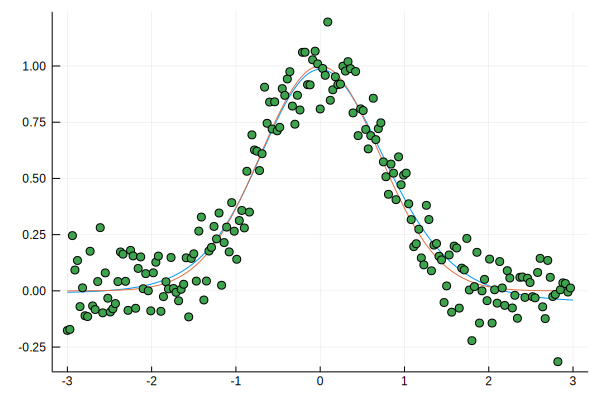

In [16]:
# Checking if the training worked. Compare the learned function with the actual gaussian
xplot=collect(-Range:0.01:Range)
# plot the converged function, the initial gaussian and the noisy training samples
plot(xplot,[predict(w,xplot)',exp.(-xplot.^2)]);
scatter!(x_train,y_train,leg=false)

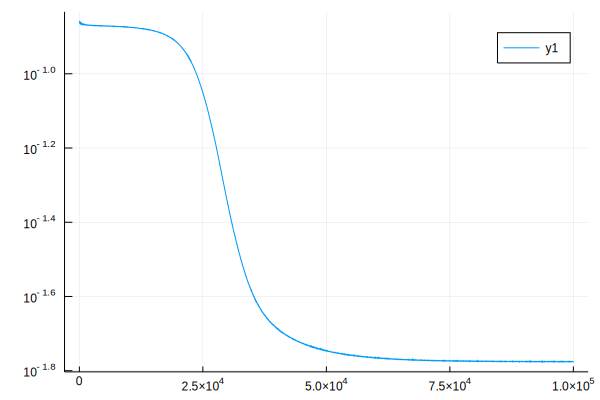

In [17]:
# Plot loss
SamplingRate=min(1,div(Nmarkov,1000));
x = collect(1:SamplingRate:Nmarkov);
y = [loss(w_training[:,i],x_train,y_train) for i in x];
#plot(x,y)
plot(x,y
#    ,xaxis=:log10
    ,yaxis=:log10
    ) # can also plot in log-log scale

## Diffusion, Hessian, Covariance Matrices

In [18]:
function diffusionmatrix(w,xt,yt,Nb,lr) # Nb = batch size
    Nweights = length(w) # number of weights, that is, dimensions of the diffusion tensor
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    V = zeros(Nweights,Nt) # initialize the diffusion matrix
    for i=1:Nt
        x=xt[i]
        y=yt[i]
        V[:,i] = lossgradient(w,[x],[y])
    end
    V /= Nt;
    dL = sqlossgradient(w,xt,yt);
    
    return lr^2 * prefac * (Nt*V*V' - dL*dL')
end

diffusionmatrix (generic function with 1 method)

In [19]:
# Calculate the diffusion tensor by sampling the noise
function diffusionmatrix_num(w,n,lr) # n: number of samples used for estimation
    wlist = zeros(Nweights,n)
    
    for i=1:n
        ww = copy(w)       
        wlist[:,i] = batchtrain!(ww,lr)
    end

    # subtract mean
    wlist .-= sum(wlist[:,i] for i=1:n)/n

    D = zeros(Nweights,Nweights)
    for α=1:Nweights
        for β=1:Nweights
            for i=1:n
                D[α,β] += wlist[α,i]*wlist[β,i]
            end
            D[α,β] /= n;
        end
    end
    return 0.5*D
end

diffusionmatrix_num (generic function with 1 method)

In [20]:
# To calculate the Hessian, define a scalar function returning ∂L/∂wⱼ
function lossgradj(w,x,y,j)
    return lossgradient(w,x,y)[j]
end

lossgradj (generic function with 1 method)

In [21]:
# Define the function returning ∂²L/∂wᵢ∂wⱼ for all i, given j (a column of the Hessian)
lossgradgrad = grad(lossgradj)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(lossgradj),Int64,Bool}}) (generic function with 1 method)

In [22]:
function hessianmatrix(w,x,y)
    Nw = length(w);
    Hess = zeros(Nw,Nw);
    for j=1:Nw
        Hess[:,j] = lossgradgrad(w,x,y,j)
    end
    return Hess
end

hessianmatrix (generic function with 1 method)

In [23]:
# This calculation is from Michael's overleaf notes:
# https://www.overleaf.com/2523873322bvvnxpwnskfk
function covariancematrix(D,H,lr) # is a function of the learning rate
    F = eigen(H);
    h = F.values
    O = F.vectors
    Nw = length(h)
    ODO = O'*D*O;
    Delta = zeros(Nw,Nw);
    for i=1:Nw
        for j=1:Nw
            Delta[i,j] = ODO[i,j]/(h[i]+h[j])
        end
    end
    return (2/lr)*O*Delta*O'
end

covariancematrix (generic function with 1 method)

### Use Newton's Method to find the minimum of loss

In [24]:
# Using Newton's method get the the true minimum of the full loss function
w = w_training[:,end];
# implement Newton's method to find the true minimum. 4 steps are enough!
for n=1:10
    Hess = hessianmatrix(w,x_train,y_train)
    gradw = lossgradient(w,x_train,y_train)
    dw = inv(Hess)*gradw
    for i=1:Nweights
        w[i] -= dw[i]
    end
end
wmin = w[:,1]

7-element Array{Float64,1}:
  1.2309808003009546 
  1.1226377819634539 
  0.6636374755671665 
 -0.6237242066102501 
  0.8857884398284767 
 -0.9024106741830754 
 -0.02678967821091651

In [25]:
lossgradient(wmin,x_train,y_train)

7-element Array{Float64,1}:
 -1.5178830414797062e-17
  7.37257477290143e-18  
  7.589415207398531e-18 
  6.071532165918825e-18 
 -5.789639601072594e-17 
 -5.139118297581291e-17 
  1.3057859914872294e-17

### Hessian at the loss minimum

In [26]:
Hessmin = hessianmatrix(wmin,x_train,y_train)

7×7 Array{Float64,2}:
  0.152251    -0.0477188   -0.159513      0.00575416   0.188115      0.288382   -0.255211
 -0.0477188    0.191185     0.00575416    0.184902    -0.349034     -0.227777   -0.290515
 -0.159513     0.00575416   0.291827     -0.161818    -0.000504538  -0.336862    0.47856 
  0.00575416   0.184902    -0.161818      0.329763    -0.375311      0.0007127  -0.533429
  0.188115    -0.349034    -0.000504538  -0.375311     1.46174       1.15104     0.348845
  0.288382    -0.227777    -0.336862      0.0007127    1.15104       1.41088    -0.379223
 -0.255211    -0.290515     0.47856      -0.533429     0.348845     -0.379223    2.002   

In [27]:
eigvals(Hessmin), norm(Hessmin)

([2.75878, 2.53553, 0.293597, 0.192422, 0.048197, 0.00595349, 0.00516699], 3.7636935681919423)

### Diffusion tensor at the loss minimum

In [28]:
# diffusion tensor at the loss minimum (using VV')
Dmin = diffusionmatrix(wmin,x_train,y_train,Batchsize,η)

7×7 Array{Float64,2}:
  1.88831e-10  -5.32896e-11  -2.04497e-10   1.99704e-11   2.25552e-10   3.63366e-10  -3.38932e-10
 -5.32896e-11   1.74339e-10   1.93927e-11   1.54906e-10  -3.50367e-10  -2.59239e-10  -2.68857e-10
 -2.04497e-10   1.93927e-11   3.28789e-10  -1.5485e-10   -5.15288e-11  -4.0503e-10    5.37777e-10
  1.99704e-11   1.54906e-10  -1.5485e-10    2.74216e-10  -3.30599e-10  -2.40275e-13  -4.98134e-10
  2.25552e-10  -3.50367e-10  -5.15288e-11  -3.30599e-10   1.59548e-9    1.35824e-9    1.39242e-10
  3.63366e-10  -2.59239e-10  -4.0503e-10   -2.40275e-13   1.35824e-9    1.65058e-9   -5.82879e-10
 -3.38932e-10  -2.68857e-10   5.37777e-10  -4.98134e-10   1.39242e-10  -5.82879e-10   2.20289e-9 

In [29]:
# compare with D calculated numerically
Dmin_num = diffusionmatrix_num(wmin,10000,η);
Dmin_num ./ Dmin

7×7 Array{Float64,2}:
 0.991519  1.0197    0.976133   0.754603  1.00563    0.983057  0.979159
 1.0197    1.00133   0.976805   1.00967   1.00678    1.00116   1.00916 
 0.976133  0.976805  0.977711   0.97474   0.905382   0.96816   0.977116
 0.754603  1.00967   0.97474    1.00224   1.02495   41.7705    0.987247
 1.00563   1.00678   0.905382   1.02495   1.00492    0.997584  1.03077 
 0.983057  1.00116   0.96816   41.7705    0.997584   0.987475  0.96846 
 0.979159  1.00916   0.977116   0.987247  1.03077    0.96846   0.996048

In [30]:
@show isapprox(Dmin_num,Dmin, rtol=0.01)
@show isapprox(Dmin_num,Dmin, rtol=0.02)

isapprox(Dmin_num, Dmin, rtol=0.01) = false
isapprox(Dmin_num, Dmin, rtol=0.02) = true


true

### Covariance matrix as a function of Hessian and Diffusion matrix

In [31]:
Covmin = covariancematrix(Dmin,Hessmin,η)

7×7 Array{Float64,2}:
  9.53257e-7  -1.76395e-8  -2.7168e-7    2.00778e-8   6.42348e-8  -5.30452e-8  -1.02505e-8
 -1.76395e-8   7.17113e-7   4.36648e-8   9.69501e-8   7.20727e-8  -1.24584e-7  -5.16229e-8
 -2.7168e-7    4.36648e-8   7.84851e-7   8.52919e-8   2.28712e-7  -2.27483e-7  -1.36924e-8
  2.00778e-8   9.69501e-8   8.52919e-8   5.90928e-7  -2.09795e-7   2.04093e-7   7.07494e-9
  6.42348e-8   7.20727e-8   2.28712e-7  -2.09795e-7   8.09326e-7   3.33188e-7  -1.04931e-7
 -5.30452e-8  -1.24584e-7  -2.27483e-7   2.04093e-7   3.33188e-7   8.12191e-7  -8.25478e-8
 -1.02505e-8  -5.16229e-8  -1.36924e-8   7.07494e-9  -1.04931e-7  -8.25478e-8   1.09935e-6

In [32]:
# verify that the math is right: HC+CH = (2/η)D
norm(Hessmin*Covmin + Covmin*Hessmin - (2/η)*Dmin) # should be zero

1.4577360391569666e-20

### Derivative of the diffusion tensor

In [33]:
# construct a scalar function returning each element of the loss gradient
# sqloss is the loss without the regularization part.
function sqlossgradj(w,x,y,j)
    return sqlossgradient(w,x,y)[j]
end

sqlossgradj (generic function with 1 method)

In [34]:
# returns ∇(∂L/∂wⱼ)
sqlossgradgrad = grad(sqlossgradj)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(sqlossgradj),Int64,Bool}}) (generic function with 1 method)

In [35]:
# Calculate ∇D. ∇D[i,j,k] ≡ ∂D[j,k]/∂wᵢ

function gradkdiffij(w,xt,yt,Nb,lr)
    Nweights = length(w) 
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    ∇D = zeros(Nweights,Nweights,Nweights)
    dL = sqlossgradient(w,xt,yt)
    ddL = hessianmatrix(w,xt,yt) - 2*RegWeight*diagm(0=>ones(Nweights)) # nly sqloss()'s 2nd derivative
    for n=1:Nt
        x=xt[n]
        y=yt[n]
        
        dLn = sqlossgradient(w,[x],[y])
        
        ddLn = zeros(Nweights,Nweights);
        for i=1:Nweights
            ddLn[:,i] = sqlossgradgrad(w,[x],[y],i)
        end
        
        for i=1:Nweights
            for j=1:Nweights
                ∇D[:,i,j] += ddLn[:,i]*dLn[j] + ddLn[:,j]*dLn[i]
            end
        end
    end
    ∇D /= Nt
    
    for i=1:Nweights
        for j=1:Nweights
            ∇D[:,i,j] -= ddL[:,i]*dL[j] + dL[i]*ddL[:,j]
        end
    end

    return lr^2 * prefac * ∇D
end

gradkdiffij (generic function with 1 method)

In [36]:
# Calculate ∇D using finite difference for validation
function gradkdiffij_num(w,xt,yt,Nb,lr;eps=1e-5)
    Nw = length(w) 
    D = diffusionmatrix(w,xt,yt,Nb,lr);
    dD = zeros(Nw,Nw,Nw);
    for i=1:Nw
        dw = zeros(Nw);
        dw[i] += eps
        dD[i,:,:] = diffusionmatrix(w+dw,xt,yt,Nb,lr)-diffusionmatrix(w-dw,xt,yt,Nb,lr);
    end
    dD /= 2*eps
    
    return dD
end

gradkdiffij_num (generic function with 1 method)

In [37]:
# Calculate ∇[inv(D)] using finite difference for validation
function gradkinvdiffij_num(w,xt,yt,Nb,lr;eps=1e-8)
    Nw = length(w) 
    Dinv = pinv(diffusionmatrix(w,xt,yt,Nb,lr));
    dDinv = zeros(Nw,Nw,Nw);
    for i=1:Nw
        dw = zeros(Nw);
        dw[i] += eps
        dDinv[i,:,:] = pinv(diffusionmatrix(w+dw,xt,yt,Nb,lr))-pinv(diffusionmatrix(w-dw,xt,yt,Nb,lr));
    end
    dDinv /= 2*eps
    
    return dDinv
end

gradkinvdiffij_num (generic function with 1 method)

In [38]:
Random.seed!(5)
w = randn(Nweights)
@time ∇D = gradkdiffij(w,x_train,y_train,Batchsize,η);

  1.492446 seconds (2.67 M allocations: 140.789 MiB, 5.79% gc time)


norm(∇D - ∇D_num) / norm(∇D) = 0.0013823398482378988


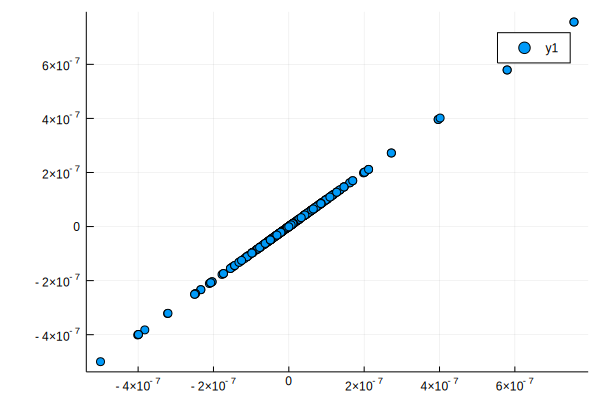

In [39]:
∇D_num = gradkdiffij_num(w,x_train,y_train,Batchsize,η,eps=1e-6);
@show norm(∇D-∇D_num)/norm(∇D)
scatter(reshape(∇D,Nweights^3,1),reshape(∇D_num,Nweights^3,1))

In [40]:
D = diffusionmatrix(w,x_train,y_train,Batchsize,η)
invD = pinv(D)
∇invD = zeros(Nweights,Nweights,Nweights)
for n=1:Nweights
    ∇invD[n,:,:] = -invD*∇D_num[n,:,:]*invD # = ∂D⁻¹/∂w_n # this works
#    ∇invD[n,:,:] = -invD*∇D[n,:,:]*invD # = ∂D⁻¹/∂w_n # this doesn't, although ∇D and ∇D_num agree to within 0.1%
end
∇invD_num = gradkinvdiffij_num(w,x_train,y_train,Batchsize,η,eps=1e-8);
norm(∇invD-∇invD_num)/norm(∇invD)

0.037072950132560824

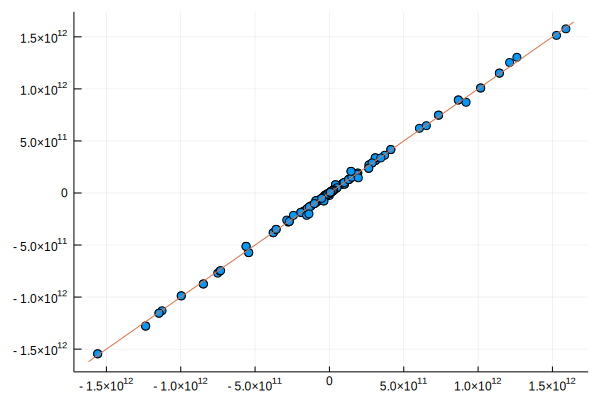

In [41]:
# What is the problem with ∇invD[n,:,:] = -invD*∇D[n,:,:]*invD in the previous cell?
scatter(reshape(∇invD,Nweights^3,1),reshape(∇invD_num,Nweights^3,1))
g(x)=x
plot!(g,leg=false)

In [42]:
@show Temp = 0.1*norm(Dmin)/η
invD = pinv(Dmin)
C = η*Temp*invD
eigvals(C)

Temp = (0.1 * norm(Dmin)) / η = 4.208736930004842e-7


7-element Array{Float64,1}:
 2985.320948885626     
  119.3920233269861    
   10.41677465770509   
    2.3559472974169693 
    1.340922140374134  
    0.12645025622346032
    0.1650380516635974 

## Thermal SGD - with C = lr\*T\*inv(Dmin)

In [43]:
function thermaltrain!(w,lr)
    perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
    x = [x_train[n] for n in perm]
    y = [y_train[n] for n in perm]
# gradient calculated on the batch
    gradw = lossgradient(w,x,y);
#update    
    dw = C*gradw # + q, but q=0
# update weights
#    w .-= lr*dw
for i=1:length(w)
    w[i] -= lr*dw[i]
end
    
return w
end

thermaltrain! (generic function with 1 method)

## Steady state

In [44]:
Random.seed!(2) # Verified that the results don't change for different seeds.
Nmarkov = 10^7;

In [45]:
w = copy(wmin); # start from the minimum of the potential

In [46]:
fname = "Gaussian-thermal-$Nmarkov-$η-$Temp.jld2"
w_ss = zeros(Nweights,Nmarkov)
if !isfile(fname)
    time0 = time() # takes about an hour for Nmarkov = 10^7
    for n = 1:Nmarkov
        w_ss[:,n] = thermaltrain!(w,η)
    end
    @show time()-time0
    Knet.save(fname, "w_ss", w_ss)
    else
        w_ss = Knet.load(fname, "w_ss");
    end
@show summary(w_ss)

summary(w_ss) = "7×10000000 Array{Float64,2}"


"7×10000000 Array{Float64,2}"

In [47]:
Nhist=10^5
skip = div(Nmarkov,Nhist)
trajloss = zeros(Nhist) 
for n=1:Nhist
    trajloss[n] = loss(w_ss[:,n*skip],x_train,y_train)
end

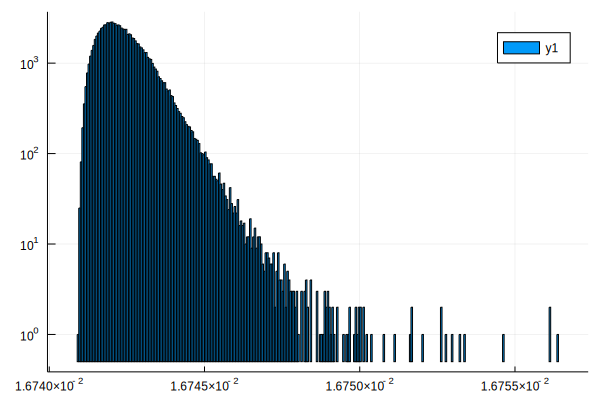

In [48]:
histogram(trajloss
    ,yaxis=:log
)
#histogram(w_ss[1,:])

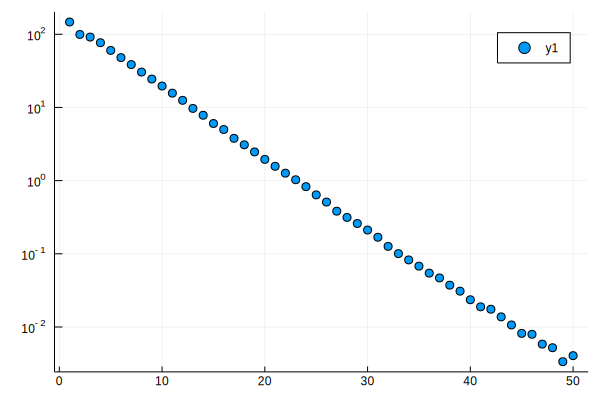

In [49]:
fith = fit(Histogram,trajloss,nbins=200)
my_y = fith.weights # bin counts
my_x = collect(1:length(my_y))
y = my_y[1:end] ./ ((my_x.-0.5)[1:end].^2.5)
y .+= 1e-10
scatter(y[1:50],yaxis=:log)

### Fit a Mv-Gaussian to the equilibrium data

In [50]:
Fit_ss = fit_mle(MvNormal,w_ss)

FullNormal(
dim: 7
μ: [1.231, 1.12277, 0.66368, -0.62379, 0.885818, -0.902422, -0.0268137]
Σ: [2.67083e-5 -8.41814e-6 … 8.42538e-6 1.22709e-6; -8.41814e-6 2.54032e-5 … 1.16102e-5 1.42562e-6; … ; 8.42538e-6 1.16102e-5 … 2.65075e-5 8.78714e-7; 1.22709e-6 1.42562e-6 … 8.78714e-7 7.07495e-7]
)


### Steady-state mean


In [51]:
w_mean = Fit_ss.μ

7-element Array{Float64,1}:
  1.2309987587140039  
  1.1227731583376455  
  0.6636799443607629  
 -0.6237902674187369  
  0.885817658973149   
 -0.9024219728926712  
 -0.026813663238012108

In [52]:
norm(w_mean-wmin)/norm(wmin)

7.118431944058679e-5

### Covariance matrix (from ss-trajectory)

In [53]:
Cov_ss = Distributions.cov(Fit_ss)

7×7 Array{Float64,2}:
  2.67083e-5  -8.41814e-6   2.63987e-5   7.08668e-6  -1.05774e-5   8.42538e-6   1.22709e-6
 -8.41814e-6   2.54032e-5  -8.47327e-6  -2.63722e-5  -9.07601e-6   1.16102e-5   1.42562e-6
  2.63987e-5  -8.47327e-6   3.74586e-5  -1.22284e-6  -2.12381e-5   1.95593e-5   2.49762e-7
  7.08668e-6  -2.63722e-5  -1.22284e-6   4.13522e-5   2.33362e-5  -2.52332e-5  -4.72471e-7
 -1.05774e-5  -9.07601e-6  -2.12381e-5   2.33362e-5   2.60109e-5  -2.58637e-5  -8.05486e-7
  8.42538e-6   1.16102e-5   1.95593e-5  -2.52332e-5  -2.58637e-5   2.65075e-5   8.78714e-7
  1.22709e-6   1.42562e-6   2.49762e-7  -4.72471e-7  -8.05486e-7   8.78714e-7   7.07495e-7

## Test thermalization: Σ⁻¹ vs H

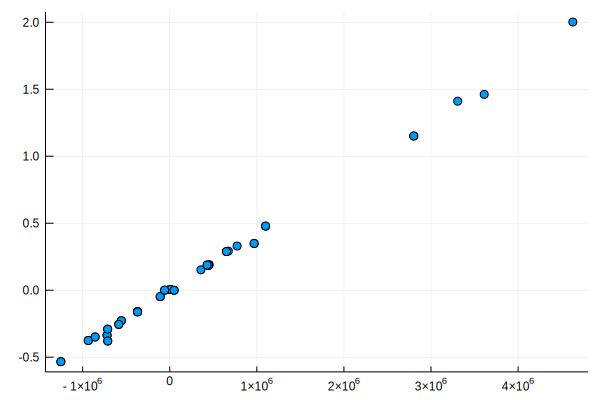

In [54]:
# Check if inv(Σ) ∝ H
scatter(reshape(inv(Cov_ss),Nweights^2,1),reshape(Hessmin,Nweights^2,1),leg=false)

### Move to the eigen-coordinates

In [55]:
# pick two eigen directions
Xid,Yid = Nweights,Nweights-1
O = eigvecs(Cov_ss);
Λ = eigvals(Cov_ss);

W_ss = O'*w_ss; # sample weights are row vectors
Wx = W_ss[Xid,:]
Wy = W_ss[Yid,:]

COV_ss = O'*Cov_ss*O # by construction diagonal
COV_xy_inv = inv(COV_ss[[Xid,Yid],[Xid,Yid]]) # this must be Diag(λx,λy)

Wmean = O'*w_mean
Wmin = O'*wmin;

In [56]:
# COV_xy_inv = Diag(λx,λy)
norm(COV_xy_inv - Diagonal([1/Λ[Xid],1/Λ[Yid]]))

9.302000671474615e-12

## Integral Fluctuation Theorem

In [57]:
## Move origin to the distribution mean
for i=1:Nmarkov
    W_ss[:,i] -= Wmean
end

In [58]:
# coarse grain the parameter space: each "quadrant" is a single state
function state(x)
    s = 1;
    for i=1:length(x)
        if (sign(x[i])>0)
            s += 2^(i-1)
        end
    end
    return s
end

# the trajectory for states
traj = zeros(Int,Nmarkov)
for i=1:Nmarkov
    traj[i] = state(W_ss[:,i])
end

In [59]:
# Calculate the ss transition matrix and the ss probability vector
W = zeros(2^Nweights,2^Nweights)
p = zeros(2^Nweights)
for i=1:Nmarkov-1
    W[traj[i+1],traj[i]] += 1
    p[traj[i]] += 1
end
W /= Nmarkov
p /= Nmarkov;

In [60]:
# check that the fluctuations in the probability vector are not sampling noise
# (if so, the magnitude of percentage fluctuations would be of order 1/√N)
mean(p),std(p)/mean(p),sqrt(length(p)/Nmarkov)

(0.0078124992187499995, 0.05399434816222934, 0.0035777087639996636)

In [61]:
# Calculate the irreversible entropy produced: ΔSⁱ
function deltaS(sampletraj)
    ΔS=0
    for i=1:length(sampletraj)-1
        ni,nim1 = sampletraj[i+1],sampletraj[i]
        if (W[nim1,ni]>0)
            ΔS += log((W[ni,nim1]*p[nim1])/(W[nim1,ni]*p[ni]))
        end
    end
    return ΔS
end

deltaS (generic function with 1 method)

In [62]:
# Divide the ss-trajectory into independent shorter trajectories
# and calculate ΔSⁱ for each
samplelen=10^2
nsamples = div(Nmarkov,samplelen)
dSs = zeros(nsamples)
for n in progress(1:nsamples)
    dSs[n] = deltaS(traj[(n-1)*samplelen+1:n*samplelen])
end

1.00e+05  100.00%┣███████████████████████████████████████████████████████████┫ 100000/100000 [00:04/00:04, 28370.42i/s]


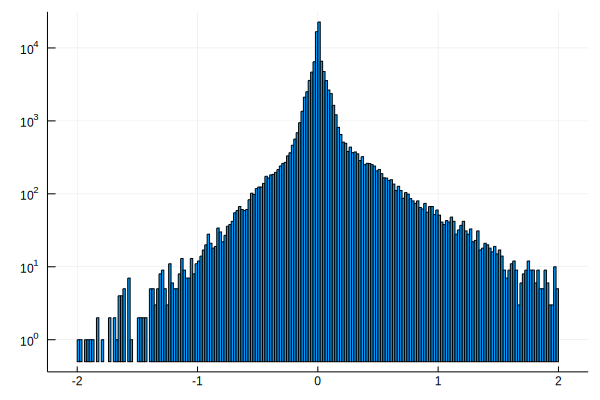

In [70]:
# check that the distribution of ΔSⁱ around zero is asymmetric
histogram(dSs
    ,yaxis=:log
    ,legend=:false
    ,bins=-2:0.02:2
)

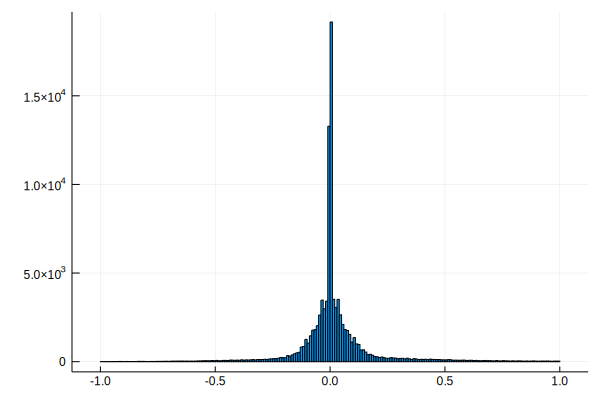

In [72]:
# check that the distribution of ΔSⁱ around zero is asymmetric
histogram(dSs
#    ,yaxis=:log
    ,legend=:false
    ,bins=-1:0.01:1
)

In [64]:
# Verify the IFT
sum(exp.(-dSs))/nsamples

0.9948165839091078

6